In [4]:
%load_ext autoreload
%autoreload 2

from df2d.model import Drosophila2DPose
from df2d.parser import create_parser
import torch

checkpoint_path = '/home/user/Desktop/DeepFly3D/weights/sh8_deepfly.tar'
args = create_parser().parse_args('')
model = Drosophila2DPose(checkpoint_path=checkpoint_path, **args.__dict__).cuda()

In [5]:
from df2d.inference import path2inp
from df2d.dataset import Drosophila2Dataset
from torch.utils.data import DataLoader

image_path = '/home/user/Desktop/DeepFly3D/data/test/'
inp = path2inp(image_path) # extract list of images under the folder
dat = DataLoader(Drosophila2Dataset(inp), batch_size=8)

In [1]:
%%time
from df2d.inference import inference
points2d = inference(model, dat)

NameError: name 'model' is not defined

In [3]:
%load_ext autoreload
%autoreload 2
from df2d.inference import inference_folder

In [20]:
import matplotlib.pyplot as plt
from df2d.inference import parse_img_path
def load_f(x):
    img = plt.imread(x)
    cam_id, _ = parse_img_path(x)
    #print(cam_id)
    if cam_id > 3:
        img = img[:, ::-1]
    return img
    

In [21]:
points2d, hm = inference_folder('/home/user/Desktop/DeepFly3D/data/test/', load_f = load_f, return_heatmap=True)

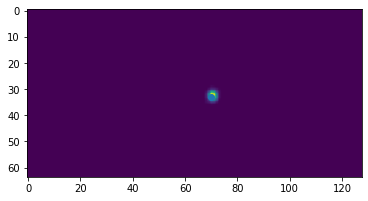

In [22]:
import matplotlib.pyplot as plt

plt.imshow(hm[0,1])
plt.scatter(points2d[0,0,1,1]*128, points2d[0,0,1,0]*64)

In [23]:
from pyba.CameraNetwork import CameraNetwork
from pyba.config import df3d_bones, df3d_colors

In [24]:
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyba.CameraNetwork import CameraNetwork
import numpy as np

cid, img_id = 0, 0
image_path = '/home/user/Desktop/DeepFly3D/data/test/camera_{cam_id}_img_00000{img_id}.jpg'
points2d_cp = np.zeros((points2d.shape[0], points2d.shape[1], points2d.shape[2]*2, 2))
points2d_cp[:3, :, :19] = points2d[:3]
points2d_cp[4:, :, 19:] = points2d[4:]
tmp = np.copy(points2d_cp[..., 0])
points2d_cp[..., 0] = points2d_cp[..., 1]
points2d_cp[..., 1] = tmp

# TODO: set necessary values to zero
cam_order = [0, 1, 2, 3, 4, 5, 6]
points2d_cp[cam_order[2], :, 15:] = 0 
points2d_cp[cam_order[4], :, 19+15:] = 0

for cidx in range(4,5,6):
    points2d_cp[cam_order[cidx], ..., ]

camNet = CameraNetwork(points2d_cp*[960, 480], image_path=image_path, bones=df3d_bones)

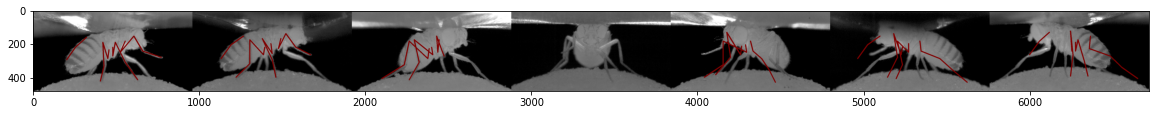

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
img = camNet.plot_2d(0)
plt.imshow(img)

In [10]:
import numpy as np
test = np.load('/home/user/Desktop/test.npy')
test2 = np.load('/home/user/Desktop/test2.npy')

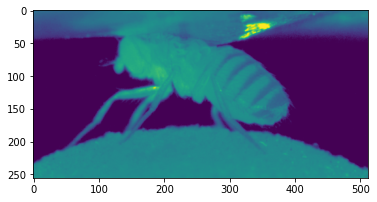

In [12]:
plt.imshow(test[0][:, ::-1])

(array([145263.,  10083.,  21747.,  33114.,  89160.,  71562.,  14619.,
          1482.,    795.,   5391.]),
 array([-0.22, -0.12, -0.02,  0.08,  0.18,  0.28,  0.38,  0.48,  0.58,
         0.68,  0.78]),
 <a list of 10 Patch objects>)

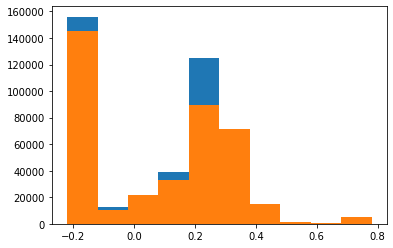

In [38]:
plt.hist(test.ravel())
plt.hist(test2.ravel())

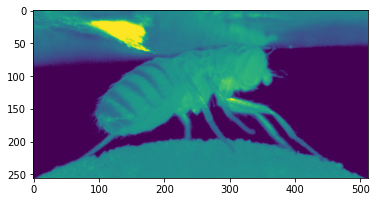

In [28]:
plt.imshow(test2[0])

In [7]:
import skimage.data as data

In [9]:
from skimage import data